# Conditioning of a 3D-DCGAN to 3 orthogonal crosssections
# Pre-trained on the Ketton dataset 

In this example we have pretrained a GAN on the Ketton limestone pore-scale training image.  
We will use the methodology of Yeh et. al. to condition GAN simulations to a 1D well.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from models import dcgan_ketton_3d
from conditioner.conditioner import Conditioner, Unconditional
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

## Load Pre-trained Networks

We have pretrained a DCGAN model with a latent vector size of 512 on the Ketton limestone training image.  
The model architecture for the generator and discriminator are defined in the models folder.

In [2]:
generator = dcgan_ketton_3d.DCGAN3D_G()
generator.load_state_dict(torch.load("./checkpoints/dcgan_ketton_3d/netG_epoch_170_cpu.pth"))
latent_size = 512

discriminator = dcgan_ketton_3d.DCGAN3D_D()
discriminator.load_state_dict(torch.load("./checkpoints/dcgan_ketton_3d/netD_epoch_170_cpu.pth"))

## Determine Latent Size

We determine first the size of the latent vector required to simulate images the size of the our conditioning data.

We can choose to do this analytically if the network architecture is known, or else empirically by scaling the latent vector.

In [3]:
uncond = Unconditional(3, generator, latent_size, "normal", use_cuda=True)
for i in range(1, 10):
    samples = uncond.create_unconditional_simulations(1, [i, i, i]) #You can choose other sizes of latent vectors
    if samples is not None:
        print "Imsize: ", i, "Uncoditional Simulation Size: ", samples.shape[2]

Imsize:  1 Uncoditional Simulation Size:  64
Imsize:  2 Uncoditional Simulation Size:  80
Imsize:  3 Uncoditional Simulation Size:  96
Imsize:  4 Uncoditional Simulation Size:  112
Imsize:  5 Uncoditional Simulation Size:  128
Imsize:  6 Uncoditional Simulation Size:  144
Imsize:  7 Uncoditional Simulation Size:  160
Imsize:  8 Uncoditional Simulation Size:  176
Imsize:  9 Uncoditional Simulation Size:  192


## Determine Trim Size

Due to border artifacts resulting from transposed convolution, it is necessary to trim outer regions when these occur.  
We determine this by sampling unconditional simulations and creating a mean and standard deviation plot. 

In our case we see little amounts of artifacts on the edges and few repeated artifacts everywhere else.

In [4]:
samples = []
for i in tqdm_notebook(range(32)):
    samples.append(uncond.create_unconditional_simulations(1, [5, 5, 5]).reshape(1, 128, 128, 128))

HBox(children=(IntProgress(value=0, max=32), HTML(value=u'')))

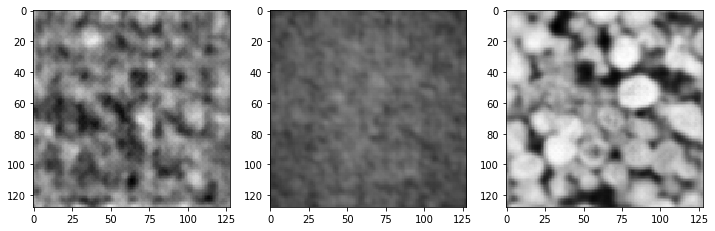

In [5]:
samples_arr = np.concatenate(samples, 0)
mean = np.mean(samples_arr, axis=0)
std = np.std(samples_arr, axis=0)

fig, ax = plt.subplots(1, 3, figsize=(12, 12))
ax[0].imshow(mean[64], cmap="gray", vmin=0.0, vmax=0.5)
ax[1].imshow(std[64], cmap="gray", vmin=0.0, vmax=1.0)
ax[2].imshow(samples_arr[0, 64], cmap="gray")

## Load conditioning data and set the conditioning mask

In this case we condition to three orthogonal cross-sections through the origin.

In [6]:
data = np.load("./datasets/ketton_3d/Ketton.npy")/255.
data = (data-0.5)/0.5
print data.min(), data.max()

-1.0 1.0


In [7]:
mask = np.zeros((128, 128, 128))
mask[mask.shape[0]/2, :, :] = 1
mask[:, mask.shape[1]/2, :] = 1
mask[:, :, mask.shape[2]/2] = 1

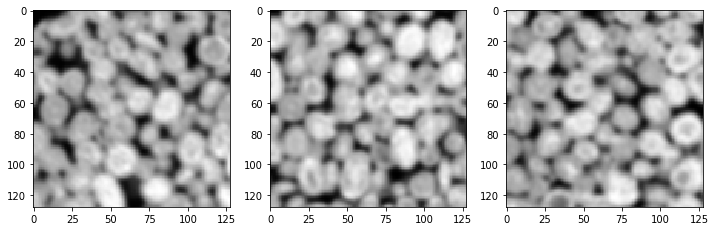

In [8]:
conditioning_data = data[0:128, 0:128, 0:128]

fig, ax = plt.subplots(1, 3, figsize=(12, 12))
ax[0].imshow(conditioning_data[64, :, :], cmap="gray")
ax[1].imshow(conditioning_data[:, 64, :], cmap="gray")
ax[2].imshow(conditioning_data[:, :, 64], cmap="gray")

## Create Conditioned Images

We now instantiate the conditioner and provide a generator, discriminator, the conditioning data and a mask.
To condition on the mse we will use Conditioner.condition().  

Our evaluation metric is the mean squared error for the mismatch on the conditioning data.

In [12]:
cond = Conditioner(3, generator, discriminator=discriminator, conditioning_data=conditioning_data, mask=mask, latent_size=latent_size, latent_dist="normal", verbose=True, use_cuda=True)

In [13]:
#We provide the latent vector size and the MSE criterion
cond.condition(1, [5, 5, 5], 1e-2*(128*128*3))
x_cond = generator(cond.zhat)

('Iteration: ', 0, 'Current MSE: 13919.9', ' Current Perceptual Loss: -0.003', ' Current Total Loss: 13919.864', ' Target MSE: 491.52')
('Iteration: ', 1, 'Current MSE: 13914.5', ' Current Perceptual Loss: -0.003', ' Current Total Loss: 13914.449', ' Target MSE: 491.52')
('Iteration: ', 2, 'Current MSE: 7068.1', ' Current Perceptual Loss: -0.003', ' Current Total Loss: 7068.068', ' Target MSE: 491.52')
('Iteration: ', 3, 'Current MSE: 6877.4', ' Current Perceptual Loss: -0.003', ' Current Total Loss: 6877.379', ' Target MSE: 491.52')
('Iteration: ', 4, 'Current MSE: 4841.3', ' Current Perceptual Loss: -0.003', ' Current Total Loss: 4841.345', ' Target MSE: 491.52')
('Iteration: ', 5, 'Current MSE: 3768.8', ' Current Perceptual Loss: -0.003', ' Current Total Loss: 3768.836', ' Target MSE: 491.52')
('Iteration: ', 6, 'Current MSE: 3227.1', ' Current Perceptual Loss: -0.003', ' Current Total Loss: 3227.090', ' Target MSE: 491.52')
('Iteration: ', 7, 'Current MSE: 2766.0', ' Current Percep

## Evaluation

In [14]:
x_cond = generator(cond.zhat)
x_hat_cond = x_cond.data.cpu().numpy()[0, 0]

The following graph compares the conditioning data (top) the conditioned GAN realization (bottom).  
The resulting images are visually very close and represent the required MSE.

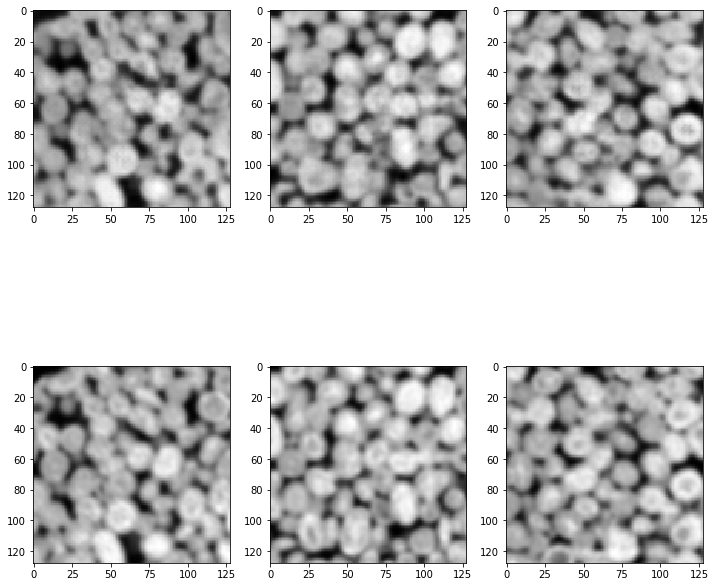

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(12, 12))
m=64
ax[0, 0].imshow(x_hat_cond[m, :, :], cmap="gray")
ax[0, 1].imshow(x_hat_cond[:, m, :], cmap="gray")
ax[0, 2].imshow(x_hat_cond[:, :, m], cmap="gray")

ax[1, 0].imshow(conditioning_data[m, :, :], cmap="gray")
ax[1, 1].imshow(conditioning_data[:, m, :], cmap="gray")
ax[1, 2].imshow(conditioning_data[:, :, m], cmap="gray")

We now compute the error by subtracting the conditioning data from the generated realization.  
The following plot shows a cross-section not through the origin.  
We hope to see a zero error where the cross-section through the origin occur and noise everywhere else.  
This indicates that our realization matches the data at the conditioning locations and represents a valid realization everywhere else within the generated volume.

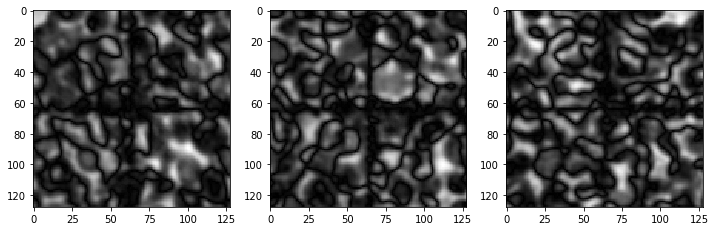

In [16]:
error = np.abs(x_hat_cond-conditioning_data)
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
ax[0].imshow(error[32, :, :], cmap="gray", vmin=0)
ax[1].imshow(error[:, 32, :], cmap="gray", vmin=0)
ax[2].imshow(error[:, :, 32], cmap="gray", vmin=0)